## Compute probability of transfer success from delays distributions

To be able to compute the probability of success of a given transfert, we use the arrival delay distribution compared with the next trip departure. To be able to do that, we need delay distributions for each trip arrival to a given station. Whenever we have a clear match, we can use an __cumulative distribution function__ to compute $P(X \leq x)$ :

$${\displaystyle F_{X}(x)=\operatorname {P} (T\leq t)=\sum _{t_{i}\leq t}\operatorname {P} (T=t_{i})=\sum _{t_{i}\leq t}p(t_{i}).}$$

The strategy was to rely entirely on past data we have to compute $p(t_i)$, without the need of building a model which imply making additionnal assumptions. If we have enough data for a given transfer with known trip_id x stop_id, we use the the abovementionned formula to compute each $p(t_i)$ by simply using :

$$p(t_i) = \frac{x_i}{\sum x_i}$$

with $x_i$ being the number of delays at time $t_i$ from SBB dataset.

### Recover missing data 

As we are using SBB data to compute delays from timetable trip_id, we may encounter problems with the translation between the two datasets (certain trip_id/stop_id have no correspondance datasets!). We may also encounter To recover missing or faulty data, the strategy is the following :

1. If we have more than 100 data points in `real` group, we rely exclusively on its delay distribution to compute probabilities for a given transfer on a `trip_id x stop_id`.

_Note : `real` group corresponds to arrival time with status `geschaetz` or `real`, meaning it comes from actual measurments._

2. If we do not find enough data within `real` group, we use delay distributions in `all` group (contains all delays including `prognose` status), if there is more than 100 data points for a given `trip_id x stop_id`.

3. If `all` group still does not have more than 100 data points, we rely on `recovery tables` to estimate delay distributions. The strategy is the following :
    - As we will always know the `stop_id`, the `time` and the `transport_type`, we rely on arrival delays from aggregated values of similar transfer. 
        - First, we compute a table of distribution with all possible combination of `stop_id`, `time` (round to hours) and `transport_type`, and aggregate all the counts we have to compute cumulative distribution probabilities. 
        - Is there is less than 100 data points in one of these intersections, we use the last possibilities : a table with `transport_type` x `time` aggregate counts.
        - The last values with no match are given the overall average of cumulative distribution probabilities for each `transport_type` with no limit for the minimum number of data points.

Following this approach, we can find cumulative distribution probabilities for every combination of `trip_id x stop_id` as defined in `stop_times_df`. We will make a table with the same row order so that McRaptor can easily find their indexes. 

In [245]:
import pickle 
import gzip
from itertools import islice
import matplotlib as mlt 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import math

In [246]:
# Functon to take a slice from a dictionnary - head equivalent
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

Load dictionnaries of distributions

In [247]:
with gzip.open("../data/distributions_geschaetzAndReal.pkl.gz", "rb") as input_file:
    d_real = pickle.load(input_file)

with gzip.open("../data/distributions_allDelays.pkl.gz", "rb") as input_file:
    d_all = pickle.load(input_file)

# display a slice of it
print('len dict_real : ', len(d_real))
print(take(5, d_real.items()))

# display a slice of it
print('len dict_all : ', len(d_all))
print(take(5, d_all.items()))

len dict_real :  6417
[('10.TA.1-11-B-j19-1.1.R__8590314', array([ 0, 84, 54, 35, 24,  5,  3,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('10.TA.1-11-B-j19-1.1.R__8590317', array([ 0, 96, 69, 36, 22,  5,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('10.TA.1-11-B-j19-1.1.R__8594304', array([ 0, 70, 78, 45, 22,  9,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('10.TA.1-11-B-j19-1.1.R__8594307', array([ 0, 87, 70, 43, 16,  5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])), ('10.TA.1-11-B-j19-1.1.R__8594310', array([ 0, 77, 65, 33, 13,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))]
len dict_all :  221945
[('1.TA.26-161-j19-1.1.H__8587347', array([  0, 2

### Probability using cumulative distribution based on frequency of delays 

When we have __enough data__ and no ambiguity about `trip_id` and `stop_id` for a given distribution, then we can compute the probability $P(T \leq t)$ for every $t$ (delay in minute). 

Let's take a __threshold of 100__ sample points (=number of time we could measure a delay) as a minimum number of points to use this approach. 

_How many keys in our distionnary of distribution have at least this number of samples ?_

In [248]:
def plot_data_points_hist(dico):
    list_tot_points = []
    for key in dico:
        distrib = dico[key]
        list_tot_points.append(np.sum(distrib))

    tot_per_key = np.array(list_tot_points)
    binwidth = 100
    n_keys_less_than_binwidth = np.sum(np.array(tot_per_key < binwidth))
    perc_key_to_recover = round(100 * ( n_keys_less_than_binwidth / len(tot_per_key) ), 2)
    plt.figure(figsize = (10,5))
    plt.hist(tot_per_key, bins = range(min(tot_per_key), max(tot_per_key) + binwidth, binwidth))
    plt.title("Total number of data points per trip_id / stop_id key. N keys with less than {0} points: {1} ({2}%)"\
             .format(binwidth, n_keys_less_than_binwidth, perc_key_to_recover))
    plt.xlabel('n data points')
    plt.ylabel('n keys')
    return plt.show()

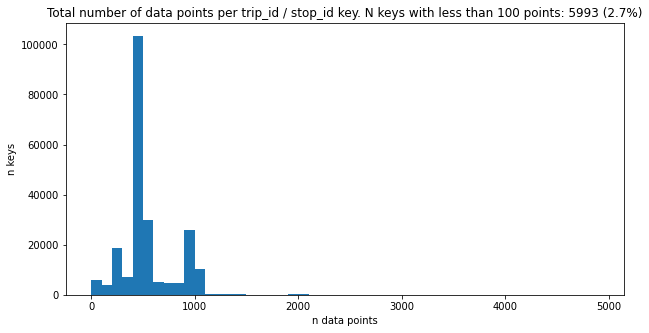

In [249]:
plot_data_points_hist(d_all)

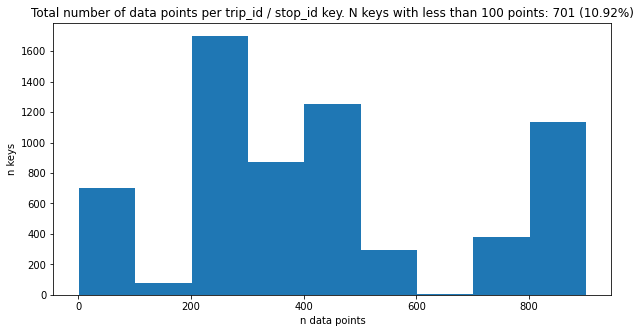

In [250]:
plot_data_points_hist(d_real)

First we generate a dictionnary with cumulative probability based on frequency of delays, for each keys in our reference dictionnary.

In [251]:
def cumul_distri_probas_dict(dico):
    list_tot_points = []
    for key in dico:
        distrib = dico[key]

        # get total number of elements 
        N = np.sum(distrib)

        # make cumulative distribution probabilities
        cdf_distrib = np.empty((len(distrib)), dtype=float)
        save_x = 0
        for x in range(len(distrib)):
            cdf_distrib[x] = float(distrib[x])/float(N) + float(save_x)/float(N)
            save_x += distrib[x]

        dico[key] = cdf_distrib
    return dico

### Construct recovery tables 

First approach is to simple sum up similar distribution to get a new distribution we can use. For that, we need to have transport type (`route_desc`), `time` (rounded to hour) and `stop_id` which are valid. We then make all combination of these tree parameters and get the associate distributions.

First we need to reformat stoptimes table in order to get time rounded to the hour, correct stop_id format and type, generate `key` column using `trip_id` and `stop_id`, and droping unnecessary columns.

In [173]:
with open("../data/stop_times_df_cyril.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)

# Use stop_id_general as stop_id  
stoptimes['stop_id'] = stoptimes['stop_id_general'].apply(str)

# Set same stoptimes index as distribution dict 
stoptimes['key'] = stoptimes['trip_id'] + '__' + stoptimes['stop_id']
stoptimes = stoptimes.set_index('key')

stoptimes = stoptimes[['trip_id','stop_id', 'route_desc', 'arrival_time', 'departure_time']]

list_hours = []
size_stop_times = stoptimes.shape[0]
for x in range(size_stop_times):
    if (x % 10000) == 0 :
        print('{}%'.format(round(100*x/size_stop_times,2)), end = ', ')
    
    arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['arrival_time']).hour
    if math.isnan(arr_time_hour): # if arrival is NaT, use departure time
        arr_time_hour = pd.to_datetime(stoptimes.iloc[x,:]['departure_time']).hour
    list_hours.append(int(arr_time_hour))
    
stoptimes['hour'] = list_hours
stoptimes = stoptimes.drop(columns=['trip_id', 'arrival_time', 'departure_time'])

# Write this pickle to avoid re-running this above code all the time
with gzip.open("../data/stop_times_wHour.pkl", "wb") as output_file:
    pickle.dump(stoptimes, output_file)         
              

0.0%, 3.84%, 7.68%, 11.52%, 15.36%, 19.2%, 23.04%, 26.88%, 30.72%, 34.55%, 38.39%, 42.23%, 46.07%, 49.91%, 53.75%, 57.59%, 61.43%, 65.27%, 69.11%, 72.95%, 76.79%, 80.63%, 84.47%, 88.31%, 92.15%, 95.98%, 99.82%, 

In [270]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)

distrib_df = pd.DataFrame(d_all).transpose()
stoptimes_df = pd.DataFrame(stoptimes)

recovery_df = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df = recovery_df.groupby(['stop_id','hour', 'route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df = recovery_df.astype('int')

print(recovery_df.shape)
recovery_df.head(4)

(16895, 32)


0    1    2   3   4   5   6   7   8   9   ...  22  \
stop_id hour route_desc                                            ...       
8500926 7    Bus         49  681  108  56  38  26  18  16   4   2  ...   0   
        8    Bus         63  700  115  61  22  10   9   5   3   7  ...   0   
        9    Bus          2  407  210  73  31  14   5   2   0   1  ...   0   
        10   Bus          0  204  121  99  47  17   5   4   2   2  ...   0   

                         23  24  25  26  27  28  29  30  31  
stop_id hour route_desc                                      
8500926 7    Bus          0   0   0   0   0   0   0   0   0  
        8    Bus          0   0   0   1   0   0   0   0   0  
        9    Bus          0   0   0   0   0   0   0   0   2  
        10   Bus          0   0   0   0   0   0   0   0   0  

[4 rows x 32 columns]

In [271]:
def plot_df_missing(df, max_bin = 10000):
    tot_per_key = np.array(df.sum(axis=1)).astype('int')
    binwidth = 100
    n_keys_less_than_binwidth = np.sum(np.array(tot_per_key < binwidth))
    perc_key_to_recover = round(100 * ( n_keys_less_than_binwidth / len(tot_per_key) ), 2)
    plt.figure(figsize = (10,5))
    plt.hist(tot_per_key, bins = range(min(tot_per_key), max_bin + binwidth, binwidth))
    plt.title("Total number of data points per stop_id / hour key. N keys with less than {0} points: {1} ({2}%)"\
             .format(binwidth, n_keys_less_than_binwidth, perc_key_to_recover))
    plt.xlabel('n data points')
    plt.ylabel('n keys')
    return plt.show()

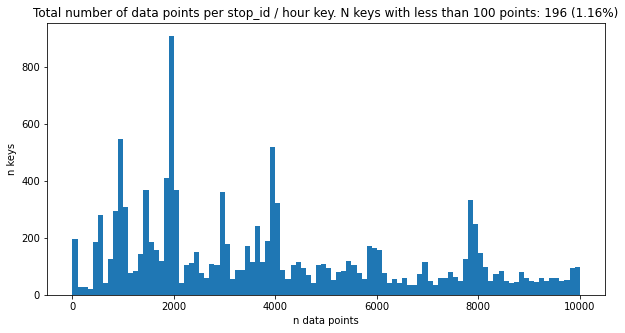

In [272]:
plot_df_missing(recovery_df)

#### Make second recovery table

Here only taking combination of `transport_type x hour`

In [259]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
distrib_df = pd.DataFrame(d_all).transpose()
distrib_to_rm = np.array(distrib_df.iloc[:,range(11)].sum(axis=1) == 11) # missing trips
distrib_df = distrib_df.iloc[~distrib_to_rm,:]

stoptimes_df = pd.DataFrame(stoptimes)

recovery_df2 = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df2 = recovery_df2.groupby(['hour', 'route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df2 = recovery_df2.astype('int')
print(recovery_df2.shape)
recovery_df2.head(4)

(39, 32)


0        1        2        3       4       5       6   \
hour route_desc                                                             
7    Bus         38120  4107332  2539805  1021932  387799  157305   73998   
     S-Bahn      97805   105802    91405    37178   13751    5179    2250   
     Tram        28177  2773595   941928   315930  114498   47608   22713   
8    Bus         36788  3507612  2269474  1040781  451125  208801  106285   

                    7      8      9   ...   22   23   24   25   26   27   28  \
hour route_desc                       ...                                      
7    Bus         39418  22943  13943  ...  342  277  282  303  237  332  228   
     S-Bahn       1176    812    640  ...   26   34   30   11    9    9    2   
     Tram        11922   6706   3954  ...  190  176  209   94  158  119   74   
8    Bus         57440  33605  20332  ...  355  280  277  200  181  246  273   

                  29   30    31  
hour route_desc                  
7    Bus         272  190  6931  
     S-Bahn        5    7    33  
     Tram         61   73  3004  
8    Bus         336  220  6591  

[4 rows x 32 columns]

#### Third recovery table 

Takes aggregated transport type distributions to make cumulative probabilities over minutes of delays

In [260]:
with gzip.open("../data/stop_times_wHour.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
distrib_df = pd.DataFrame(d_all).transpose()

stoptimes_df = pd.DataFrame(stoptimes)

recovery_df3 = distrib_df.join(stoptimes_df)
list_bins = [x for x in range(32)]

recovery_df3 = recovery_df3.groupby(['route_desc'])[list_bins].apply(lambda x : x.astype(float).sum())
recovery_df3 = recovery_df3.astype('int')
print(recovery_df3.shape)
recovery_df3.head(4)

(3, 32)


0         1         2         3        4        5       6   \
route_desc                                                                   
Bus         363268  36683792  23736240  10576138  4388686  1928373  951454   
S-Bahn      978390   1105562    826122    300372   108761    41031   17883   
Tram        247447  25497756   9524532   3371924  1289451   553734  262423   

                7       8       9   ...    22    23    24    25    26    27  \
route_desc                          ...                                       
Bus         516108  303852  193705  ...  5812  4984  4531  4406  3942  4194   
S-Bahn        9170    5731    4066  ...   183   180   115    87    73    56   
Tram        135400   77638   47291  ...  1986  1953  1794  1508  1278  1321   

              28    29    30     31  
route_desc                           
Bus         3517  3662  3192  63646  
S-Bahn        49    36    42    246  
Tram        1018  1021   867  33074  

[3 rows x 32 columns]

#### Overall aggregate distribution (used when it fails)

In [261]:
last_chance_distrib = np.array(recovery_df3.sum(axis=0))

### Reconstruct cumulative distribution probabilities from multiple distributions to recover data with few/missing points 

At this point, we have 2 dictionnaries of distributions and 3 recovery dataframes :

 - `d_real` : contains delay distribution for each keys in form `trip_id + __ + stop_id` calculated from delays with status `geschaetz` or `real` in sbb datasets.
 - `d_all` : contains delay distributions for each keys in form `trip_id + __ + stop_id`. No filter was applied on status (contains `geschaetz`, `real` __and__ `prognose` = evaluated delay).
 - `recovery_df` : contains aggregated delay distributions for each combination of `stop_id`, `route_desc` (transport type) and `hour` (time rounded to hour). 
 - `recovery_df2` : contains aggregated delay distributions for each combination of `route_desc` (transport type) and `hour` (time rounded to hour). 
 - `recovery_df3` : contains aggregated delay distributions for `route_desc` (transport type) 
 - `last_chance_distrib` : contains aggregated delay from all lines
 
We will now use these in order to reconstruct the final table with $P(T\leq t_i)$ for each time points between -1 and +30, using a cumulative probability function as mentionned above.

In [276]:
###################### MAKE CUMULATIVE PROBABILITY TABLE #######################

# Load stop_time table, to use its order as a template for our final table 
with open("../data/stop_times_df_cyril.pkl", "rb") as input_file:
    stoptimes = pickle.load(input_file)
    
# declare empty variables 
size_stop_times = stoptimes.shape[0]
n_fail = n_real = n_all = n_recov1 = n_recov2 = n_recov3 = i = 0
all_distrib, all_transport_type, all_hours, all_keys, all_failure_keys, all_data_origin = \
    ([] for i in range(6))

# Get useful indexes
stop_id_idx = stoptimes.columns.get_loc("stop_id_general")
trip_id_idx = stoptimes.columns.get_loc("trip_id")
transport_type_idx = stoptimes.columns.get_loc("route_desc")

for index, row in stoptimes.iterrows():
    
    trip_id = row[trip_id_idx]
    stop_id = str(row[stop_id_idx])
    transport_type = row[transport_type_idx]
    key = str(trip_id) + '__' + str(stop_id)

    # Compute rounded hour using arrival if possible - recover with departure
    hour = pd.to_datetime(stoptimes.loc[index]['arrival_time']).hour
    if math.isnan(hour): # if arrival is NaT, use departure time
        hour = pd.to_datetime(stoptimes.loc[index]['departure_time']).hour
    
    distrib = np.zeros(31)
    keep_trying = True
    
    # 1) try d_real to get distribution from measured delays
    if key in d_real:
        distrib = d_real[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_real += 1
            all_data_origin.append('d_real')
    
    # 2) try d_all to get distribution from measured + estimated delays
    if keep_trying and key in d_all:
        distrib = d_all[key]
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False
            n_all += 1
            all_data_origin.append('d_all')

            
    # 3) try first recovery table using stop_id, transport_type and hour
    if keep_trying and (stop_id, hour, transport_type) in recovery_df.index:
        distrib = np.array(recovery_df.loc[(stop_id, hour, transport_type)])
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_recov1 += 1
            all_data_origin.append('recov_tab1')
            
    # 4) use second recovery table using transport_type and hour 
    if keep_trying and (hour, transport_type) in recovery_df2.index:
        distrib = np.array(recovery_df2.loc[(hour, transport_type)])
        sum_distrib = np.sum(distrib)
        if sum_distrib > 100 :
            #summary_df.loc[index, 'distribution'] = distrib
            all_distrib.append(distrib)
            keep_trying = False 
            n_recov2 += 1
            all_data_origin.append('recov_tab2')
    
    # 5) use third recovery table using transport_type only 
    if keep_trying and (transport_type) in recovery_df3.index:
        distrib = np.array(recovery_df3.loc[(transport_type)])
        sum_distrib = np.sum(distrib)
        #summary_df.loc[index, 'distribution'] = distrib
        all_distrib.append(distrib)
        keep_trying = False 
        n_recov3 += 1
        all_data_origin.append('recov_tab3')

    # Record results in summary
    all_keys.append(key)
    all_transport_type.append(transport_type)
    all_hours.append(hour)

    # save number of failure for recovery
    if keep_trying:
        #print('fail{}'.format(index), end = ', ')
        all_distrib.append(last_chance_distrib)
        all_failure_keys.append(key)
        n_fail += 1 
        all_data_origin.append('fail')
        
    # print progression 
    if (index % 10000) == 0 :
        print('{}%'.format(round(100*index/size_stop_times,2)), end = ', ')

0.0%, 3.84%, 7.68%, 11.52%, 15.36%, 19.2%, 23.04%, 26.88%, 30.72%, 34.55%, 38.39%, 42.23%, 46.07%, 49.91%, 53.75%, 57.59%, 61.43%, 65.27%, 69.11%, 72.95%, 76.79%, 80.63%, 84.47%, 88.31%, 92.15%, 95.98%, 99.82%, 

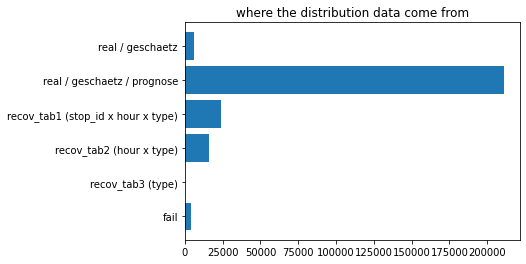

In [277]:
plt.barh(np.array(['real / geschaetz','real / geschaetz / prognose','recov_tab1 (stop_id x hour x type)','recov_tab2 (hour x type)','recov_tab3 (type)', 'fail'])[::-1],\
         np.array([n_real,n_all,n_recov1,n_recov2, n_recov3, n_fail])[::-1])
plt.title('where the distribution data come from')
plt.show()

In [279]:
summary_df = pd.DataFrame([all_keys, all_hours, all_transport_type, all_distrib, all_data_origin],\
                          index = ['key','hour','transport_type','distribution', 'origin']).transpose()
summary_df.head()

key hour transport_type  \
0  2064.TA.26-13-j19-1.24.H__8576240    7           Tram   
1  2064.TA.26-13-j19-1.24.H__8591353    7           Tram   
2  2064.TA.26-13-j19-1.24.H__8591039    7           Tram   
3  2064.TA.26-13-j19-1.24.H__8591121    7           Tram   
4  2064.TA.26-13-j19-1.24.H__8591417    7           Tram   

                                        distribution origin  
0  [15, 445, 31, 4, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,...  d_all  
1  [1, 442, 41, 11, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,...  d_all  
2  [0, 415, 68, 11, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0,...  d_all  
3  [0, 403, 79, 12, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,...  d_all  
4  [0, 388, 79, 24, 4, 1, 0, 1, 0, 0, 0, 0, 1, 0,...  d_all

In [309]:
print(stoptimes.iloc[np.array(stoptimes['route_desc'] == 'Eurocity'),:][['trip_id','stop_id_general']])

                        trip_id  stop_id_general
167848  35.TA.40-5-Y-j19-1.33.H          8503000
167849  35.TA.40-5-Y-j19-1.33.H          8503016
167886    8.TA.40-5-Y-j19-1.8.H          8503000
167887    8.TA.40-5-Y-j19-1.8.H          8503016
167920  16.TA.40-5-Y-j19-1.16.H          8503000
167921  16.TA.40-5-Y-j19-1.16.H          8503016
251450  18.TA.40-4-Y-j19-1.16.H          8503016
251451  18.TA.40-4-Y-j19-1.16.H          8503000


In [311]:
summary_df.loc[np.array(summary_df['key'] == '1326.TA.26-8-C-j19-1.8.R'),:]

Empty DataFrame
Columns: [key, hour, transport_type, distribution, origin]
Index: []

Write down summary table used to make final distribution

In [240]:
with gzip.open("../data/join_distribution_all.pkl.gz", "wb") as out_file:
    pickle.dump(summary_df, out_file)

In [241]:
list_all_rows = []
for index, row in summary_df.iterrows():
    distrib = np.array(row['distribution'])
    
    # get total number of elements 
    N = np.sum(distrib)
        
    # make cumulative distribution probabilities
    cdf_distrib = np.empty((len(distrib)), dtype=float)
    save_x = 0
    for x in range(len(distrib)):
        cdf_distrib[x] = float(distrib[x])/float(N) + float(save_x)/float(N)
        save_x += distrib[x]
        
    list_all_rows.append(cdf_distrib)

In [242]:
final_df = pd.DataFrame(list_all_rows)
final_df.index = summary_df.index
final_np = final_df.to_numpy()
final_np[0:5,:]

array([[0.03314917, 0.88950276, 0.97237569, 0.98895028, 0.98895028,
        0.98895028, 0.99447514, 0.99447514, 0.99447514, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.        , 0.85082873, 0.95027624, 0.98895028, 0.98895028,
        0.98895028, 0.98895028, 0.99447514, 0.99447514, 0.99447514,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.        , 0.77348066, 0.94475138, 0.98895028, 0.98895028,
        0.98895028, 0.98895028, 0.99447514, 0.9944

Last check if all indexes corresponds to `stoptimes` indexes :

In [243]:
sum(np.array(final_df.index == stoptimes.index)) == stoptimes.shape[0]

True

In [244]:
# write recovery table 
with gzip.open("../data/join_distribution_cumulative_p_3.pkl.gz", "wb") as output_file:
    pickle.dump(final_np, output_file)

### Poisson cumulative distribution

The Poisson distribution is popular for modeling the number of times an event occurs in an interval of time or space. We modeled a poisson distribution for delays assuming parameter $k$ is the time in minutes (as it was done [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126137), formulas $(4),(5),(6)$).

A discrete random variable X is said to have a Poisson distribution with parameter λ > 0, if, for k = 0, 1, 2, ..., the probability mass function of X is given by:

$${\displaystyle \!f(k;\lambda )=\Pr(X=k)={\frac {\lambda ^{k}e^{-\lambda }}{k!}},}$$
where

e is Euler's number (e = 2.71828...)
k! is the factorial of k.
The positive real number λ is equal to the expected value of X __and__ to its variance.

$${\displaystyle \lambda =\operatorname {E} (X)=\operatorname {Var} (X)}$$

We can approximate E[𝑋]∼$\mu_i$ for our data $X_i$, if we assume the sample $X_i$ of size N follow the distribution of $X$ meaning $X_i$∼$X$.

Poisson-related __assumptions__ :
- $k$ is the __delay time in minutes__ and can take values 0, 1, 2, ... (strictly positive and discrete)
- We assume our sampling $X_i$ of $X$ is good enough to approximate E[X] ~ $\mu_i$
- The occurrence of one event does not affect probability of others. That is, events occur independently.
    - __We assume being late one day is not affecting the delay of the day after__ 
- The average rate at which events occur is independent of any occurrences. For simplicity, this is usually assumed to be constant, but may in practice vary with time.
    - __we assumes delays occurs with a constant rate over time__
- Two events cannot occur at exactly the same instant

We made a function `poisson_proba` that takes a `trip_id`, a `stop_id`, an `arrival time` and a `departure time` and a dictionnary {key : distribution} to compute a __probability to be at least 2 minutes before departure of next trip__. 

We make a few __assumptions__ on our side :
- We assume that if we have less than 2 minutes for the transfer, we miss it.
- We assume the next train is on time.
- As for poisson distribution $k$ is strictly positive, we assume trains ahead of schedule were on time ($k=0$)


_Question we should address :_
- _Is the poisson a reasonable approximation of the binomial distribution in our case ?_

Let's first test the poisson distribution and compare it with our distribution to see how well it fits the data. We will compute $Pr(X = k)$ for each values of k and look at the shape of the poisson distribution compared to the shape of our scaled data. Then, we will compare $\sum_{k=0}^T Pr(X = k)$ with the cumulative distribution function which directly gives $Pr(k \leq X)$

In [22]:
################################# POISSON FIT TEST #########################################

# to do .. 


An error was encountered:
Invalid status code '404' from http://iccluster044.iccluster.epfl.ch:8998/sessions/6821 with error payload: "Session '6821' not found."


Here are all the functions needed to calculate probability of success for a given transfer. We need the `trip_id`, `stop_id`, `departure_time`, `arrival_time` and dictionnary `d` (pickled load at the beginning of the cell) to be able to compute a probability of success with following function : 

`poisson_proba(trip_id, stop_id, arrival_time, departure_time, d)`

In [40]:
%local
################################# POISSON FUNCTIONS ########################################

import pickle 
import gzip
import time
import math 
import datetime
import time
from scipy.stats import poisson

# Load dictionnary
with gzip.open("../data/distributions.pickle", "rb") as input_file:
    d = pickle.load(input_file)

# Load dictionnary
with open("../data/stop_times_array.pkl", "rb") as input_file:
    times = pickle.load(input_file)

# we take two exemple time in format numpy.datetime64
arr_time = times[4][1]
dep_time = times[0][1]

# Load distribution in dictinonary given a key
def get_distrib(key, dico):
    if key in dico:
        return dico[key]
    else:
        raise ValueError("KEY ERROR: {} not found un distribution dictionnary".format(key))
    
# Evaluate lambda parameter assuming it is equal to average 
def evaluate_lamda(distrib):
    # First calculate total number of measures N
    N = 0 # by starting at -1 we ignore trains ahead of schedule
    for x in distrib:
        N += x

    lambda_p = 0 # expectation - we want to calculate it
    t        = -1 # time = index - 1

    for x in distrib:
        if t>0:
            lambda_p += t*x
        t += 1

    # calculate lambda - the expectation of x
    if N > 0:
        lambda_p /= N 
        print('lambda (expectation given distribution): ',lambda_p, '\n')
        return lambda_p
    else : 
        raise ValueError("ERROR : {} distribution has 0 counts".format(key))
        #print('Returning 1 to avoid later problem... \n')
        return 1

# process time given as string in format 'hh:mm' - not needed
def process_time_str(str_time):
    x = time.strptime(str_time,'%H:%M')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

# Calculate transfer time given two times in string format 'hh:mm'
def get_transfer_time(arr_time, dep_time, delta=2.0):
    diff_time_min = (arr_time - dep_time).astype('timedelta64[m]') / np.timedelta64(1, 'm')
    return diff_time_min - delta

# Calculate poisson probability of success for a given transfert 
# for a given trip_id, stop_id, arrival/departure times and dict
def poisson_proba(trip_id, stop_id, arr_time, dep_time, dico):
    # Generate key from trip_id / stop_id 
    key = str(trip_id) + '__' + str(stop_id[0:7]) # 7 first char to be sbb-compatible

    # Get distribution from dictionnary
    distrib = get_distrib(key, dico)
    
    # Calculate transfer time at disposal 
    T = get_transfer_time(arr_time, dep_time)
    
    # Get lambda value to calculate proba
    lambda_p = evaluate_lamda(distrib)

    # Get proba
    if T > 2:
        poisson_p = poisson.cdf(T, lambda_p)
    else : 
        poisson_p = 0.0 # if we have less than 2 minutes, we miss it
        
    print('Probability of success for transfer time = {} minutes : '.format(T),poisson_p)
    return poisson_p

# Mock exemple of probability calculations with given inputs
trip_id = '1286.TA.26-32-j19-1.12.H'
stop_id = '8591184'

# we take two exemple time from stop_times_array in format numpy.datetime64
arr_time = times[3][1]
dep_time = times[0][1]

Pr = poisson_proba(trip_id, stop_id, arr_time, dep_time, d)


lambda (expectation given distribution):  1.0194769059543685 

Probability of success for transfer time = 13.0 minutes :  0.999999999994185
